In [2]:
import numpy as np
import torch, os, cv2
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
N = 55
R, C = 580, 890
M = R*C
W = 25

In [3]:
# bring captured image

# 580, 890, N, 3 / N : illumination 개수
# b = np.stack([cv2.imread("test_2023_05_08_13_16_160ms_crop/calibration0/capture_%04d.png"%i) for i in range(N)], axis=2)
# b = b[:,:,:,::-1]/255.
# print(b.shape)

In [4]:
# HDR
# b = np.load("./hdr.npy") / 65535.
b = np.load("./hdr_fat.npy") / 65535.
b = b[:,:,:,::-1]

In [5]:
b.shape

(580, 890, 55, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


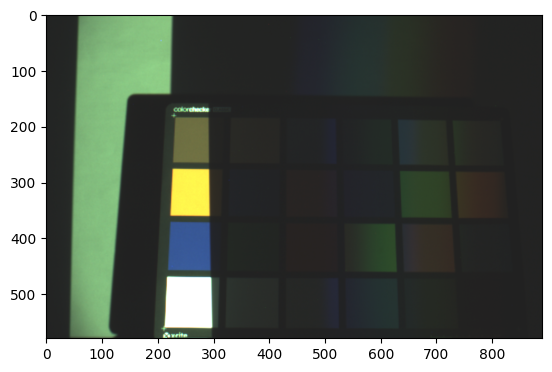

In [19]:
plt.imshow(b[:,:,12,:])

In [7]:
A = np.load("./illum_data_fat_line.npy")[0]

In [8]:
A.shape

(516200, 55, 25)

In [9]:
A_tmp = A.reshape(580,890,55,25)

In [10]:
# bring camera response function
# 25, 3
cam_crf = np.load(os.path.join("./dataset/image_formation/CRF_cam.npy"))
map_scale = interp1d([cam_crf.min(), cam_crf.max()], [0.,1.])
cam_crf = map_scale(cam_crf).astype(np.float32)
cam_crf = cam_crf[2:27].T
print(cam_crf.shape)

(3, 25)


In [13]:
A_rgb = (A_tmp @ cam_crf.T) # .sum(axis = 4)

In [14]:
A_rgb.shape

(580, 890, 55, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


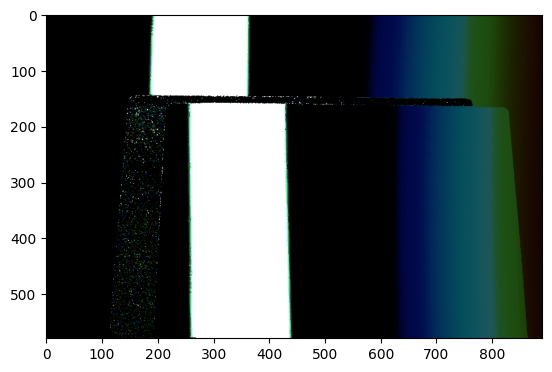

In [15]:
plt.imshow(A_rgb[:,:,20])

In [6]:
# bring illumination numpy array
# 580, 890, 40, 25
# A = np.load("./illum_data_0.6.npy")[0]
# A = np.load("./illum_data_0.6.npy")[0]
A = np.load("./illum_data_fat_line.npy")[0]
print(A.shape)

(516200, 55, 25)


In [7]:
# bring camera response function
# 25, 3
cam_crf = np.load(os.path.join("./dataset/image_formation/CRF_cam.npy"))
map_scale = interp1d([cam_crf.min(), cam_crf.max()], [0.,1.])
cam_crf = map_scale(cam_crf).astype(np.float32)
cam_crf = cam_crf[2:27].T
print(cam_crf.shape)

(3, 25)


In [8]:
# Make M N 3 W

A = np.expand_dims(A, axis=2)
cam_crf = np.expand_dims(np.expand_dims(cam_crf, axis =0), axis=0)
A = A * cam_crf

In [9]:
def total_variation_loss_l2(img, weight): 
    bs_img, c_img, h_img, w_img = img.size() 
    tv_h = torch.pow(img[:,:,1:,:]-img[:,:,:-1,:], 2).sum() 
    tv_w = torch.pow(img[:,:,:,1:]-img[:,:,:,:-1], 2).sum() 
    return weight*(tv_h+tv_w)/(bs_img*c_img*h_img*w_img)

In [10]:
def total_variation_loss_l1(img, weight): 
    bs_img, c_img, h_img, w_img = img.size() 
    tv_h = torch.abs(img[:,:,1:,:]-img[:,:,:-1,:]).sum() 
    tv_w = torch.abs(img[:,:,:,1:]-img[:,:,:,:-1]).sum() 
    return weight*(tv_h+tv_w)/(bs_img*c_img*h_img*w_img)

In [11]:
def total_variation_loss_l2_spectrum(img, weight): 
    bs_img, c_img, h_img, w_img = img.size() 
    tv_s = torch.pow(img[:,1:,:,:]-img[:,:-1,:,:], 2).sum()
    return weight*(tv_s)/(bs_img*c_img*h_img*w_img)

### Optimize with TV Loss + L1 loss

In [12]:
# Reshape for tv loss

r, c = 290, 445

A = A.reshape(R, C, 1, 3*N, W)
b = b.reshape(R, C, 1, 3*N, 1)

A1 = A[:r,:c]
A2 = A[:r,c:]
A3 = A[r:,:c]
A4 = A[r:,c:]

b1 = b[:r,:c]
b2 = b[:r,c:]
b3 = b[r:,:c]
b4 = b[r:,c:]

A_list = [A1,A2,A3,A4]
b_list = [b1,b2,b3,b4]

In [13]:
batch_size = 100000
num_iter = 5000
num_batches = int(np.ceil(M / batch_size))
loss_f = torch.nn.L1Loss()
losses = []
X_np_all = torch.zeros(R, C, 1, W, 1)

# define initial learning rate and decay step
lr = 1
decay_step = 500


# training loop over batches
for batch_idx in range(len(A_list)):
    A_batch = torch.from_numpy(A_list[batch_idx]).to(device).reshape(r*c,1, 3*N, W)
    B_batch = torch.from_numpy(b_list[batch_idx]).to(device).reshape(r*c,1, 3*N, 1)
    X_est = torch.randn(r*c, 1, W, 1, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([X_est], lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=0.5)

    optimizer.zero_grad()
    for i in range(num_iter):
        loss = loss_f(A_batch @ X_est, B_batch)
        X_est_reshape = X_est.reshape(r,c,W).unsqueeze(dim = 0).permute(0,3,1,2)
        loss_tv = total_variation_loss_l1(X_est_reshape, 0.1)
        loss_spec = total_variation_loss_l2_spectrum(X_est_reshape, 0.1)
        total_loss = loss + loss_tv + loss_spec
        
        total_loss.backward()
        losses.append(total_loss.item())
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if i % 100 == 0:
            print(f"Batch {batch_idx + 1}/{len(A_list)}, Iteration {i}/{num_iter}, Loss: {loss.item()}, TV Loss: {loss_tv.item()}, Spec Loss: {loss_spec.item()},  LR: {optimizer.param_groups[0]['lr']}")

    if batch_idx == 0:
        X_np_all[:r,:c]= X_est.detach().cpu().reshape(r,c,1,W,1)
    elif batch_idx == 1:
        X_np_all[:r,c:]= X_est.detach().cpu().reshape(r,c,1,W,1)
    elif batch_idx == 2:
        X_np_all[r:,:c]= X_est.detach().cpu().reshape(r,c,1,W,1)
    else:
        X_np_all[r:,c:]= X_est.detach().cpu().reshape(r,c,1,W,1)

X_np_all = X_np_all.numpy()

Batch 1/4, Iteration 0/5000, Loss: 0.24280784471224953, TV Loss: 0.2250291407108307, Spec Loss: 0.1922762393951416,  LR: 1
Batch 1/4, Iteration 100/5000, Loss: 0.1219611328606382, TV Loss: 0.022163735702633858, Spec Loss: 0.001827617990784347,  LR: 1
Batch 1/4, Iteration 200/5000, Loss: 0.12207400932326493, TV Loss: 0.02230062335729599, Spec Loss: 0.0018292675958946347,  LR: 1
Batch 1/4, Iteration 300/5000, Loss: 0.12209785037307212, TV Loss: 0.02232702076435089, Spec Loss: 0.0018287275452166796,  LR: 1
Batch 1/4, Iteration 400/5000, Loss: 0.12214525568775389, TV Loss: 0.022343456745147705, Spec Loss: 0.0018293238244950771,  LR: 1
Batch 1/4, Iteration 500/5000, Loss: 0.12211398508194733, TV Loss: 0.022364987060427666, Spec Loss: 0.0018300212686881423,  LR: 0.5
Batch 1/4, Iteration 600/5000, Loss: 0.1141622602560791, TV Loss: 0.01122886873781681, Spec Loss: 0.001099387533031404,  LR: 0.5
Batch 1/4, Iteration 700/5000, Loss: 0.11422458932647592, TV Loss: 0.011319272220134735, Spec Loss: 

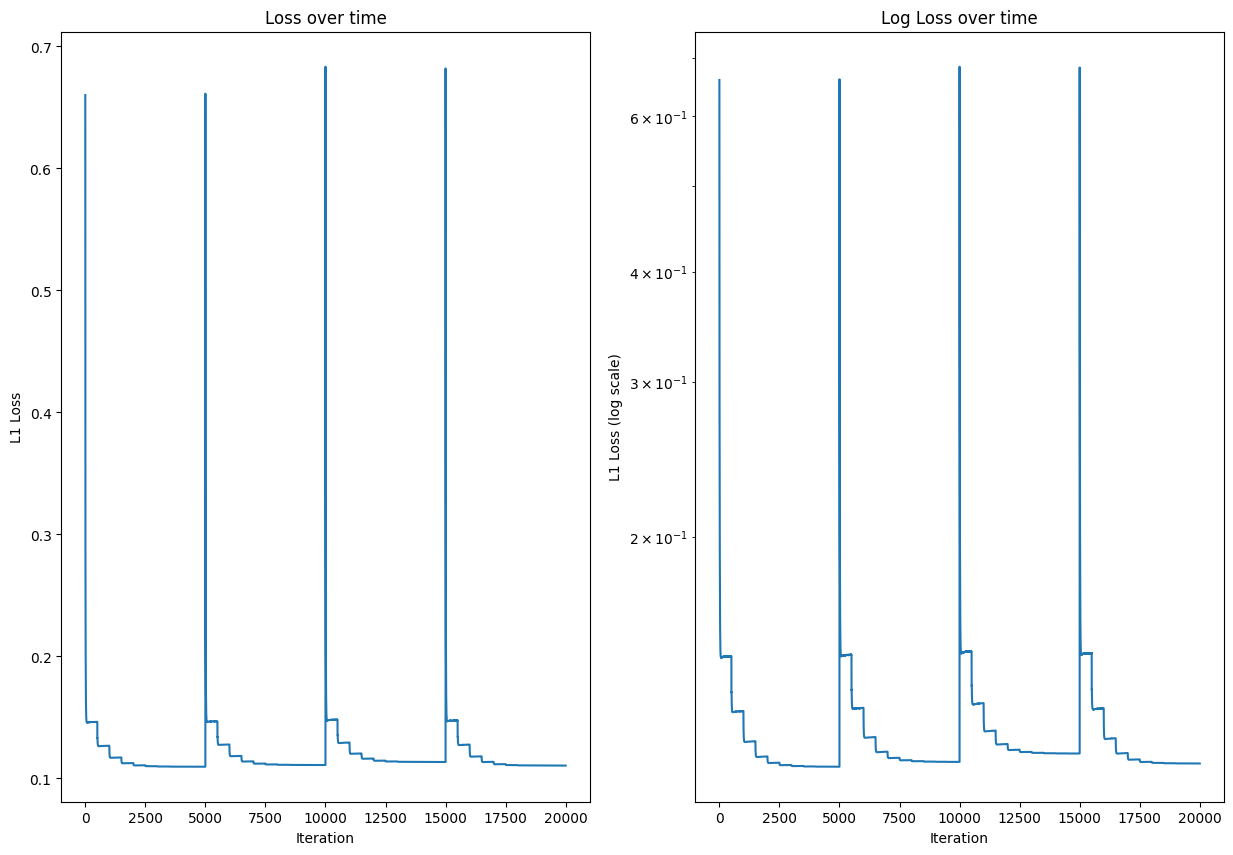

In [14]:
# plot losses over time
plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Loss over time")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss")

plt.subplot(1, 2, 2)
plt.semilogy(losses)
plt.title("Log Loss over time")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss (log scale)")

plt.show()


In [15]:
X_np_all = X_np_all.reshape(R, C, W)

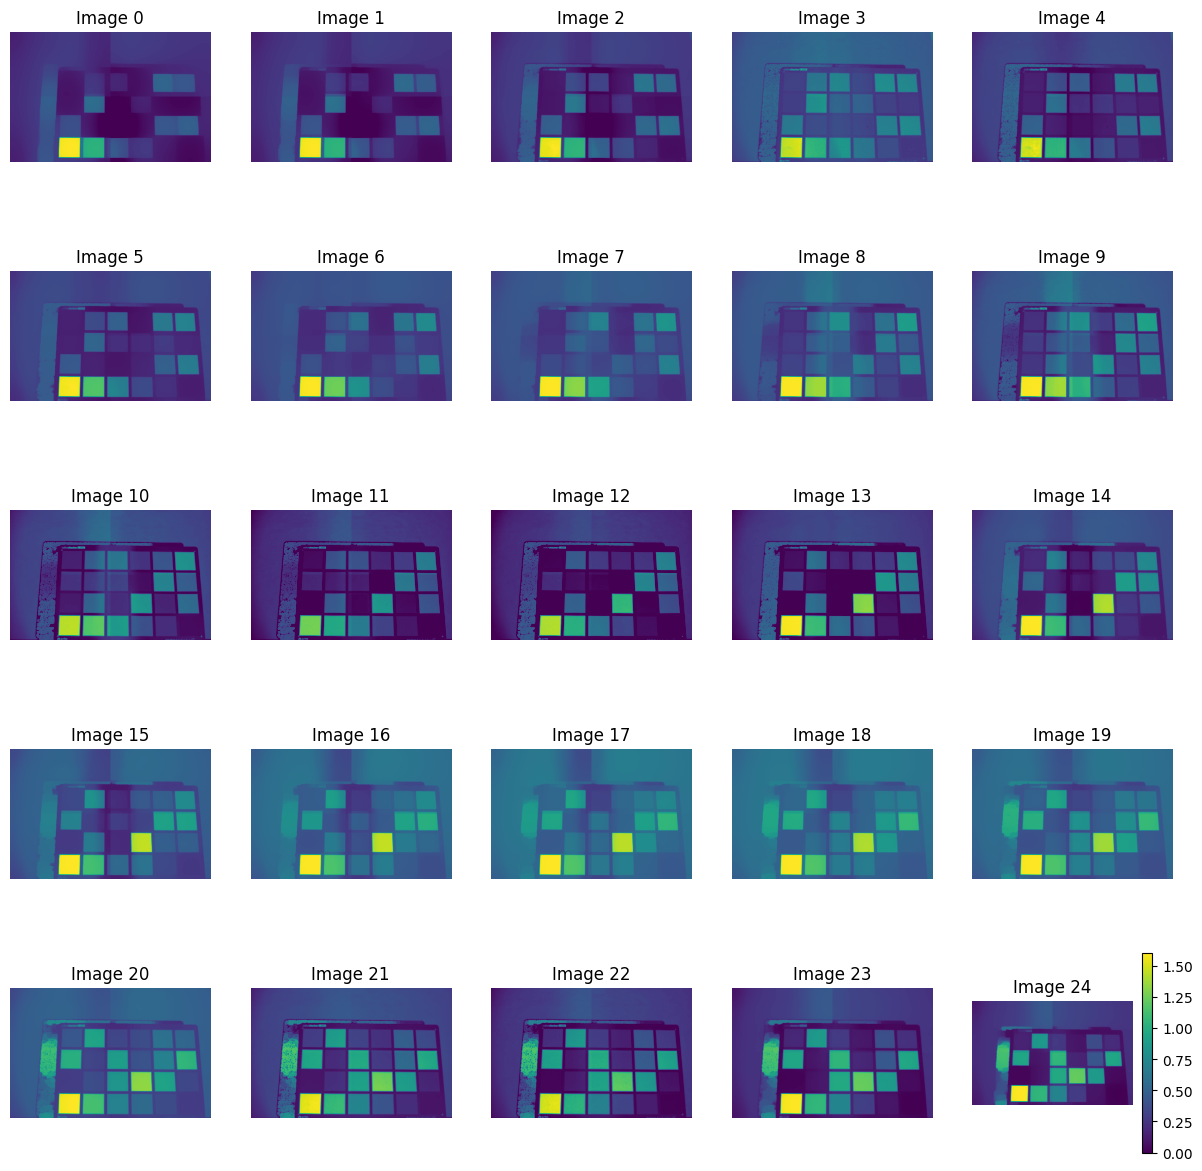

In [16]:
max_images_per_column = 5
num_columns = (W + max_images_per_column - 1) // max_images_per_column
plt.figure(figsize=(15, 3*num_columns))

for c in range(num_columns):
    start_index = c * max_images_per_column
    end_index = min(start_index + max_images_per_column, W)
    num_images = end_index - start_index
    
    for i in range(num_images):
        plt.subplot(num_columns, num_images, i + c * num_images + 1)
        plt.imshow(X_np_all[:, :, i + start_index], vmin=0)
        plt.axis('off')
        plt.title(f"Image {i + start_index}")
        
        if i + start_index == W - 1:
            plt.colorbar()

In [17]:
X_np_all.shape

(580, 890, 25)

In [18]:
np.save('./X_np_all_fat_tv.npy', X_np_all)

In [19]:
CRF = cam_crf.reshape(3,25).T

In [20]:
X_np_all.shape

(580, 890, 25)

In [21]:
rgb_img = X_np_all@CRF

In [22]:
rgb_img.max()

15.853324

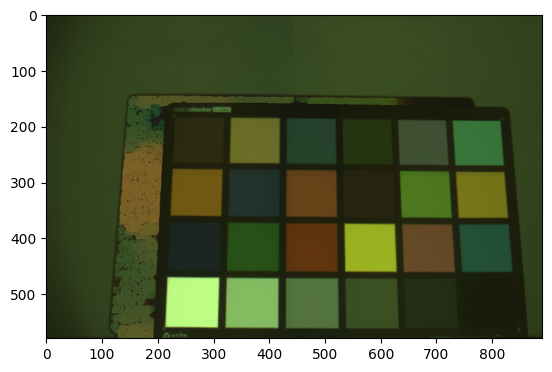

In [23]:
plt.imshow(rgb_img/ rgb_img.max())